冪函数と指数関数が混ざった関数で分散スペクトルをフィッティングする。
そのパラメータによって指数減衰なのか冪減衰なのかを判定する。

In [1]:
import pickle
from h5py import File
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import pearsonr
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator

In [33]:
path = '/root/code/paper_public/data'
    
with open(f"{path}/date_all.pkl","rb") as f:
    date_all = pickle.load(f)
with open(f"{path}/DIV_all.pkl","rb") as f:
    DIV_all = pickle.load(f)
with open(f"{path}/varspec_all.pkl","rb") as f:
    varspec_all = pickle.load(f)
# with open(f"{path}/varspec_shuffle_all.pkl","rb") as f:
#     varspec_shuffle_all = pickle.load(f)
with open(f"{path}/varspec_shift_all.pkl","rb") as f:
    varspec_shift_all = pickle.load(f)
with open(f"{path}/varspec_shift_all.pkl","rb") as f:
    varspec_ind_all = pickle.load(f)
with open(f"{path}/firingrate_all.pkl","rb") as f:
    firingrate_all = pickle.load(f)
    
path = '/root/code/paper_public/result'
with open(f"{path}/size_hist_all.pkl","rb") as f:
    size_hist_all = pickle.load(f)
# with open(f"{path}/size_time_hist_all.pkl","rb") as f:
#     size_time_hist_all = pickle.load(f)

In [27]:

with open("/root/code/paper_public/data/varspec_shift_all.pkl","rb") as f:
    varspec_ind_all = pickle.load(f)

(-4.0, 3.0)

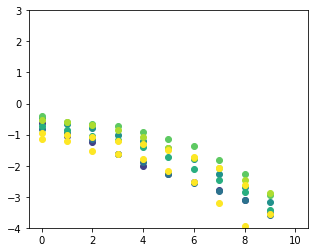

In [4]:
dish = '19880'

date_dish = date_all[dish]
DIV_dish = DIV_all[dish]
varspec_dish = varspec_all[dish]
i_list = [1,2,4,6,8,10,12,14]

fig, ax = plt.subplots(figsize=(5,4))
for i in i_list[::-1]:
    x_fit = np.arange(0,11)
    y_fit = np.log10(varspec_dish[i][2**x_fit-1])
    ax.scatter(x_fit,y_fit, color=cm.viridis(1-(DIV_dish[i]-3)/(19-3)))
    
ax.set_ylim([-4,3])

In [34]:
def optimize_parameters(x, y, func, initial_params):
    """
    x座標、y座標、および関数に基づいてパラメータを最適化する関数。

    Args:
        x (array-like): x座標のデータ
        y (array-like): y座標のデータ（観測値）
        func (callable): パラメータを含む関数 func(x, *params)
        initial_params (array-like): パラメータの初期値

    Returns:
        result (OptimizeResult): scipy.optimize.minimizeの結果オブジェクト
    """
    # 二乗和誤差を計算する目的関数
    def sse(params):
        y_pred = func(x, *params)
        return np.sum((y - y_pred) ** 2)
    
    # scipy.optimize.minimizeで最適化
    result = minimize(sse, initial_params)
    return result

def power_exp(x, a, b, c):
    return -a * x - b*np.exp(x) + c
def power(x, a, c):
    return -a * x + c

-0.61765399142243 0.36199987955836394


<ipython-input-16-8a878e101c31>:18: RuntimeWarning: divide by zero encountered in log10
  y_log = np.log10(varspec_shuffle_dish[i][0,x_fit])


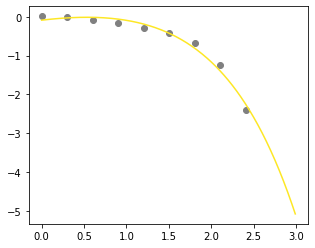

In [16]:
dish = '23311'

date_dish = date_all[dish]
DIV_dish = DIV_all[dish]
varspec_dish = varspec_all[dish]
varspec_shuffle_dish = varspec_shuffle_all[dish]
fig, ax = plt.subplots(figsize=(5,4))

x_fit = 2**np.arange(0,11) - 1
x_log = np.log10(x_fit+1)
x_plot = np.arange(0,3,0.01)
initial_guess = [1.2,0.0,1.0]
yllim = -7

# for i in range(len(date_dish)):
for i in [11]:
# for i in [1,2,4,6,8,10,12,14]:
    y_log = np.log10(varspec_shuffle_dish[i][0,x_fit])
    ax.scatter(x_log[y_log>yllim],y_log[y_log>yllim],color='gray')

# ax.set_ylim([-4,3])

    result = optimize_parameters(x_log[y_log>yllim], y_log[y_log>yllim], power_exp, initial_guess)
    a,b,c = result.x

    ax.plot(x_plot, -a*x_plot -b*np.exp(x_plot)+c, color=cm.viridis((b+0.1)/0.4))
    # # 結果の表示
    print(a,b)
    

In [35]:
abc_all = {}
abc_shuffle_all = {}
abc_shift_all = {}
abc_ind_all = {}

x_fit = 2**np.arange(1,11) - 1
x_log = np.log10(x_fit+1)
initial_guess = [1.2,0.0,1.0]
yllim = -7

for dish, date_list in date_all.items():
    if dish in varspec_all:
        abc_dish = []
        abc_shuffle_dish = []
        abc_shift_dish = []
        abc_ind_dish = []
        for d in range(len(date_list)):
            y_log = np.log10(varspec_all[dish][d][x_fit])
            result = optimize_parameters(x_log[y_log>yllim], y_log[y_log>yllim], power_exp, initial_guess)
            a,b,c = result.x
            if b > 0:
                abc_dish.append([a,b,c])
            else:
                result = optimize_parameters(x_log[y_log>yllim], y_log[y_log>yllim], power, [a,c])
                a,c = result.x
                abc_dish.append([a,0,c])
            
            abc_temp = []
            # N_shuffle = len(varspec_shuffle_all[dish][d][:,0])
            # for i_shuffle in range(N_shuffle):
            #     y_log = np.log10(varspec_shuffle_all[dish][d][i_shuffle,x_fit])
            #     result = optimize_parameters(x_log[y_log>yllim], y_log[y_log>yllim], power_exp, initial_guess)
            #     a,b,c = result.x
            #     if b > 0:
            #         abc_temp.append([a,b,c])
            #     else:
            #         result = optimize_parameters(x_log[y_log>yllim], y_log[y_log>yllim], power, [a,c])
            #         a,c = result.x
            #         abc_temp.append([a,0,c])
            # abc_shuffle_dish.append(abc_temp)
            
            y_log = np.log10(varspec_shift_all[dish][d][x_fit])
            result = optimize_parameters(x_log[y_log>yllim], y_log[y_log>yllim], power_exp, initial_guess)
            a,b,c = result.x
            if b > 0:
                abc_shift_dish.append([a,b,c])
            else:
                result = optimize_parameters(x_log[y_log>yllim], y_log[y_log>yllim], power, [a,c])
                a,c = result.x
                abc_shift_dish.append([a,0,c])
                
            y_log = np.log10(varspec_ind_all[dish][d][x_fit])
            result = optimize_parameters(x_log[y_log>yllim], y_log[y_log>yllim], power_exp, initial_guess)
            a,b,c = result.x
            if b > 0:
                abc_ind_dish.append([a,b,c])
            else:
                result = optimize_parameters(x_log[y_log>yllim], y_log[y_log>yllim], power, [a,c])
                a,c = result.x
                abc_ind_dish.append([a,0,c])
                
                
    abc_all[dish] = abc_dish
    abc_shuffle_all[dish] = abc_shuffle_dish
    abc_shift_all[dish] = abc_shift_dish
    abc_ind_all[dish] = abc_ind_dish

<ipython-input-35-ee6138750c9e>:18: RuntimeWarning: divide by zero encountered in log10
  y_log = np.log10(varspec_all[dish][d][x_fit])
<ipython-input-35-ee6138750c9e>:42: RuntimeWarning: divide by zero encountered in log10
  y_log = np.log10(varspec_shift_all[dish][d][x_fit])
<ipython-input-35-ee6138750c9e>:52: RuntimeWarning: divide by zero encountered in log10
  y_log = np.log10(varspec_ind_all[dish][d][x_fit])


NameError: name 'expness_shuffle_all' is not defined

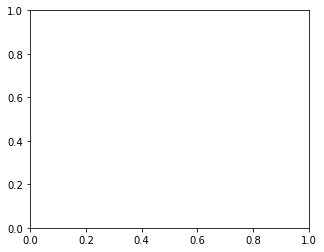

In [14]:
dish_list = ["19880","23312","23280","23311","23317","23302","23282"]
dish = '23311'

date_dish = date_all[dish]
DIV_dish = DIV_all[dish]
varspec_dish = varspec_all[dish]
varspec_shuffle_dish = varspec_shuffle_all[dish]

i_list = [1,2,4,6,8,10,12,14]
fig, ax = plt.subplots(figsize=(5,4))

x_axis = np.arange(1, 1025, 1)
# for i in i_list[::-1]:
for i in range(len(date_dish)):
    b = expness_shuffle_all[dish][i][0]
    ax.plot()
    ax.plot(x_axis, varspec_shuffle_dish[i][0,:], label=int(DIV_dish[i]), color=cm.viridis((b+0.1)/0.4), linewidth=4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('k: PC dimension', fontsize=20)
ax.set_ylabel('Variance along k-th PC', fontsize=20)
ax.set_ylim([1e-7,1e3])

plt.legend()
plt.show()

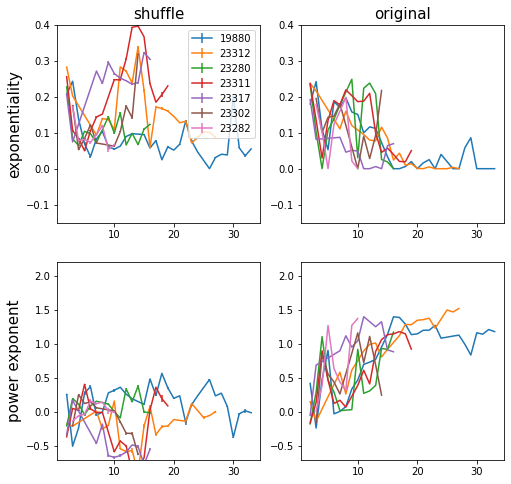

In [15]:
dish_list = ["19880","23312","23280","23311","23317","23302","23282"]

fig, axes = plt.subplots(2,2,figsize=(8,8))
ax1, ax2, ax3, ax4 = axes.flatten()

for dish in dish_list:
    date_ok = np.where(np.array(firingrate_all[dish]) > 0.03)[0]
    
    y = np.average(abc_shuffle_all[dish],axis=1)[:,1]
    yerr = np.std(abc_shuffle_all[dish],axis=1)[:,1]
    ax1.errorbar(DIV_all[dish][date_ok],y=y[date_ok],yerr=yerr[date_ok],label=dish)
    
    ax2.plot(DIV_all[dish][date_ok], np.array(abc_all[dish])[date_ok,1],label=dish)
    
    y = np.average(abc_shuffle_all[dish],axis=1)[:,0]
    yerr = np.std(abc_shuffle_all[dish],axis=1)[:,0]
    ax3.errorbar(DIV_all[dish][date_ok],y=y[date_ok],yerr=yerr[date_ok],label=dish)
    
    ax4.plot(DIV_all[dish][date_ok], np.array(abc_all[dish])[date_ok,0],label=dish)
        
        
ax1.set_ylim([-0.15,0.4])
ax1.set_ylabel('exponentiality', fontsize=15)
ax1.legend()
ax1.set_title('shuffle', fontsize=15)
ax2.set_ylim([-0.15,0.4])
ax2.set_title('original', fontsize=15)

ax3.set_ylim([-0.7,2.2])
ax3.set_ylabel('power exponent', fontsize=15)
ax4.set_ylim([-0.7,2.2])
plt.show()

<ipython-input-36-120cb4600c5c>:34: RuntimeWarning: invalid value encountered in divide
  a_mvavg /= mvavg_counter
<ipython-input-36-120cb4600c5c>:35: RuntimeWarning: invalid value encountered in divide
  b_mvavg /= mvavg_counter


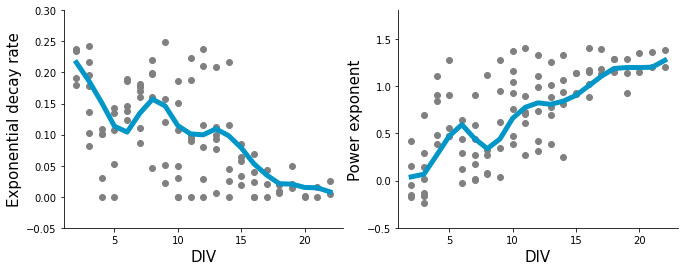

In [36]:
dish_list = ["19880","23312","23280","23311","23317","23302","23282"]

fig, axes = plt.subplots(1,2,figsize=(11,4))
ax2, ax1 = axes.flatten()

firingrate_thr = 0.03
DIV_min_plot = 0 # determine left limit
DIV_max_plot = 23 # right limit
window = 3 # window size for moving average
    
a_array = np.zeros((len(dish_list),DIV_max_plot-DIV_min_plot))
b_array = np.zeros((len(dish_list),DIV_max_plot))

for d in range(len(dish_list)):
    dish = dish_list[d]
    DIV_list = DIV_all[dish]
    date_list = np.where((np.array(firingrate_all[dish]) > firingrate_thr) * (DIV_list < DIV_max_plot) * (DIV_list >= DIV_min_plot))[0]
    ax1.scatter(DIV_all[dish][date_list], np.array(abc_all[dish])[date_list,0],label=dish,color='gray')
    ax2.scatter(DIV_all[dish][date_list], np.array(abc_all[dish])[date_list,1],label=dish,color='gray')
    
    for date in date_list:
        a_array[d,int(DIV_list[date])-DIV_min_plot] = np.array(abc_all[dish])[date,0]
        b_array[d,int(DIV_list[date])-DIV_min_plot] = np.array(abc_all[dish])[date,1]
    
date_ok = np.where(np.sum(a_array,axis=0)!=0)[0]
a_mvavg = np.zeros(DIV_max_plot) # moving average
b_mvavg = np.zeros(DIV_max_plot) # moving average
mvavg_counter = np.zeros(DIV_max_plot)
for date in date_ok:
    a_mvavg[max(0,date):date+window] += np.sum(a_array[a_array[:,date]!=0,date])
    b_mvavg[max(0,date):date+window] += np.sum(b_array[b_array[:,date]!=0,date])
    mvavg_counter[max(0,date):date+window] += np.sum(a_array[:,date]!=0)

a_mvavg /= mvavg_counter
b_mvavg /= mvavg_counter

ax1.plot(np.arange(DIV_min_plot, DIV_max_plot)[date_ok], a_mvavg[date_ok],linewidth=5, color='#0096C8')
ax2.plot(np.arange(DIV_min_plot, DIV_max_plot)[date_ok], b_mvavg[date_ok],linewidth=5, color='#0096C8')
        
ax1.set_ylim([-0.5,1.8])
ax1.set_xlabel('DIV', fontsize=15)
ax1.set_ylabel('Power exponent', fontsize=15)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks([5,10,15,20])

ax2.set_ylim([-0.05,0.3])
ax2.set_xlabel('DIV', fontsize=15)
ax2.set_ylabel('Exponential decay rate', fontsize=15)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xticks([5,10,15,20])

# plt.savefig("/root/code/paper_public/figs/fig1F.eps")
plt.show()

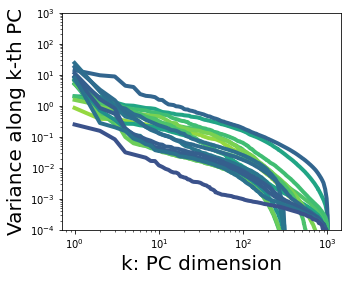

In [6]:
dish_list = ["19880","23312","23280","23311","23317","23302","23282"]
dish = '23311'

date_dish = date_all[dish]
DIV_dish = DIV_all[dish]
varspec_dish = varspec_all[dish]

i_list = [1,2,4,6,8,10,12,14]
fig, ax = plt.subplots(figsize=(5,4))

x_axis = np.arange(1, 1025, 1)
# for i in i_list[::-1]:
for i in range(len(date_dish)):
    b = abc_all[dish][i][1]
    ax.plot(x_axis, varspec_dish[i], label=int(DIV_dish[i]), color=cm.viridis((b+0.1)/0.4), linewidth=4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('k: PC dimension', fontsize=20)
ax.set_ylabel('Variance along k-th PC', fontsize=20)
ax.set_ylim([1e-4,1e3])

plt.show()

-0.9024037573990786 1.2692769444392482
-1.6289099844489552 1.6540605648550193
1.7527588213270566 0
1.41659676431962 0
2.0775931851280784 0
-0.5663720311618315 1.044556739127492
1.0609753430064828 0.6275379452831599
2.5672858840988413 0
1.160106784515539 0
1.805040463781939 0
1.064942482062157 0
1.629797815044976 0
-0.8592352391795878 0.9554320622132579
-0.6988562662403424 1.150334752986632
-0.5343384200013777 1.0366184217910321
-1.4781777977125348 1.6316374268767684


<ipython-input-7-56e13fe46a95>:24: RuntimeWarning: invalid value encountered in scalar divide
  y_log[x] = np.log10(np.sum(size_hist[x_fit[x-1]+2:x_fit[x]+2])/np.count_nonzero(size_hist[x_fit[x-1]+2:x_fit[x]+2]))


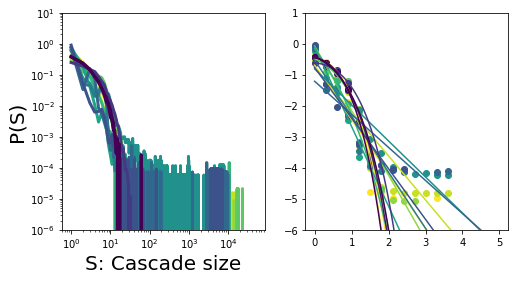

In [7]:
dish_list = ["19880","23312","23280","23311","23317","23302","23282"]
dish = '23302'

date_dish = date_all[dish]
DIV_dish = DIV_all[dish]
size_hist_dish = size_hist_all[dish]
x_plot = np.arange(0,5,0.01)
initial_guess = [1.5,0.0,0.0]
yllim = -15

i_list = [2,4,6,8,10,12,14]
fig, axes = plt.subplots(1,2,figsize=(8,4))
ax1, ax2 = axes

# for i in i_list[::-1]:
for i in range(len(date_dish)):
# for i in range(10):
    size_hist = size_hist_dish[i]
    x_fit = np.array([int(x) -1  for x in 2**np.arange(0,np.log2(np.where(size_hist>0)[0][-1])-1)])
    x_log = np.log10(x_fit+1)
    y_log = np.zeros(len(x_fit))
    y_log[0] = np.log10(size_hist[1])
    for x in range(1,len(x_fit)):
        y_log[x] = np.log10(np.sum(size_hist[x_fit[x-1]+2:x_fit[x]+2])/np.count_nonzero(size_hist[x_fit[x-1]+2:x_fit[x]+2]))
    ax2.scatter(x_log, y_log, color=cm.viridis(1-(i-i_list[0])/(i_list[-1]-i_list[0])))
    result = optimize_parameters(x_log[y_log>yllim], y_log[y_log>yllim], power_exp, initial_guess)
    a,b,c = result.x
    if b < 0:
        result = optimize_parameters(x_log[y_log>yllim], y_log[y_log>yllim], power, [a,c])
        a,c = result.x
        b = 0
    print(a,b)

    ax2.plot(x_plot, -a*x_plot -b*np.exp(x_plot)+c, color=cm.viridis(1-(i-i_list[0])/(i_list[-1]-i_list[0])))
        
    ax1.plot(np.arange(1, len(size_hist_dish[i])), size_hist_dish[i][1:], label=int(DIV_dish[i]), color=cm.viridis(1-(i-i_list[0])/(i_list[-1]-i_list[0])), linewidth=3)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('S: Cascade size', fontsize=20)
ax1.set_ylabel('P(S)', fontsize=20)
ax1.set_ylim([1e-6,1e1])
ax2.set_ylim([-6,1])
# ax.set_ylim([1e-4,1e3])

plt.show()

In [19]:
type(np.log2(np.where(size_hist>0)[0][-1]))

numpy.float64

In [27]:
NA_abc_all = {}

initial_guess = [1.5,0.0,0.0]
yllim = -15

for dish, date_list in date_all.items():
    if dish in size_hist_all:
        NA_abc_dish = []
        NA_abc_time_dish = []
        for d in range(len(date_list)):
            size_hist = size_hist_all[dish][d]
            indices = np.where(size_hist > 0)[0]
            
            if indices.size > 0:  # Check if indices array is not empty
                last_index = indices[-1]  # Get the last index
                log_value = np.log2(last_index)
                result = min(log_value, 7)  # Compare log value with 10
            else:
                result = 7  # Default value if size_hist has no non-zero values

            x_fit = np.array([int(x) -1  for x in 2**np.arange(0,result)])
            x_log = np.log10(x_fit+1)
            y_log = np.zeros(len(x_fit))
            y_log[0] = np.log10(size_hist[1])
            for x in range(1,len(x_fit)):
                y_log[x] = np.log10(np.sum(size_hist[x_fit[x-1]+2:x_fit[x]+2])/np.count_nonzero(size_hist[x_fit[x-1]+2:x_fit[x]+2]))
            result = optimize_parameters(x_log[y_log>yllim], y_log[y_log>yllim], power_exp, initial_guess)
            a,b,c = result.x
            if b > 0:
                NA_abc_dish.append([a,b,c])
            else:
                result = optimize_parameters(x_log[y_log>yllim], y_log[y_log>yllim], power, [a,c])
                a,c = result.x
                NA_abc_dish.append([a,0,c])

    NA_abc_all[dish] = NA_abc_dish

<ipython-input-27-c2cf75013390>:26: RuntimeWarning: invalid value encountered in scalar divide
  y_log[x] = np.log10(np.sum(size_hist[x_fit[x-1]+2:x_fit[x]+2])/np.count_nonzero(size_hist[x_fit[x-1]+2:x_fit[x]+2]))


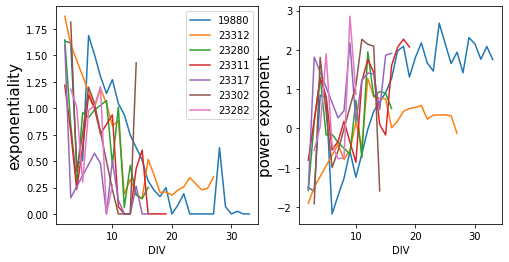

In [37]:
dish_list = ["19880","23312","23280","23311","23317","23302","23282"]

fig, axes = plt.subplots(1,2,figsize=(8,4))
ax1, ax2 = axes.flatten()
for dish in dish_list:
    date_ok = np.where(np.array(firingrate_all[dish]) > 0.03)[0]
    ax1.plot(np.array(DIV_all[dish])[date_ok], np.array(NA_abc_all[dish])[date_ok,1], label=dish)
    ax2.plot(np.array(DIV_all[dish])[date_ok], np.array(NA_abc_all[dish])[date_ok,0], label=dish)

ax1.set_xlabel('DIV')
ax1.set_ylabel('exponentiality',fontsize=15)
ax2.set_xlabel('DIV')
ax2.set_ylabel('power exponent',fontsize=15)
ax1.legend()    
plt.show()    

<ipython-input-38-e65064d33d79>:34: RuntimeWarning: invalid value encountered in divide
  NA_a_mvavg /= mvavg_counter
<ipython-input-38-e65064d33d79>:35: RuntimeWarning: invalid value encountered in divide
  NA_b_mvavg /= mvavg_counter


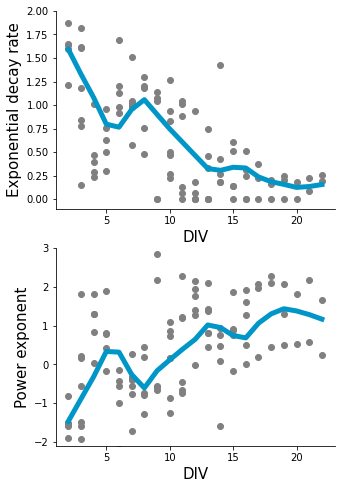

In [38]:
dish_list = ["19880","23312","23280","23311","23317","23302","23282"]

fig, axes = plt.subplots(2,1,figsize=(5,8))
ax2, ax1 = axes.flatten()

firingrate_thr = 0.03
DIV_min_plot = 0 # determine left limit
DIV_max_plot = 23 # right limit
window = 3 # window size for moving average
    
NA_a_array = np.zeros((len(dish_list),DIV_max_plot-DIV_min_plot))
NA_b_array = np.zeros((len(dish_list),DIV_max_plot))

for d in range(len(dish_list)):
    dish = dish_list[d]
    DIV_list = DIV_all[dish]
    date_list = np.where((np.array(firingrate_all[dish]) > firingrate_thr) * (DIV_list < DIV_max_plot) * (DIV_list >= DIV_min_plot))[0]
    ax1.scatter(DIV_all[dish][date_list], np.array(NA_abc_all[dish])[date_list,0],label=dish,color='gray')
    ax2.scatter(DIV_all[dish][date_list], np.array(NA_abc_all[dish])[date_list,1],label=dish,color='gray')
    
    for date in date_list:
        NA_a_array[d,int(DIV_list[date])-DIV_min_plot] = np.array(NA_abc_all[dish])[date,0]
        NA_b_array[d,int(DIV_list[date])-DIV_min_plot] = np.array(NA_abc_all[dish])[date,1]
    
date_ok = np.where(np.sum(NA_a_array,axis=0)!=0)[0]
NA_a_mvavg = np.zeros(DIV_max_plot) # moving average
NA_b_mvavg = np.zeros(DIV_max_plot) # moving average
mvavg_counter = np.zeros(DIV_max_plot)
for date in date_ok:
    NA_a_mvavg[max(0,date):date+window] += np.sum(NA_a_array[NA_a_array[:,date]!=0,date])
    NA_b_mvavg[max(0,date):date+window] += np.sum(NA_b_array[NA_b_array[:,date]!=0,date])
    mvavg_counter[max(0,date):date+window] += np.sum(NA_a_array[:,date]!=0)

NA_a_mvavg /= mvavg_counter
NA_b_mvavg /= mvavg_counter

ax1.plot(np.arange(DIV_min_plot, DIV_max_plot)[date_ok], NA_a_mvavg[date_ok],linewidth=5, color='#0096C8')
ax2.plot(np.arange(DIV_min_plot, DIV_max_plot)[date_ok], NA_b_mvavg[date_ok],linewidth=5, color='#0096C8')
        
ax1.set_ylim([-2.1,3])
ax1.set_xlabel('DIV', fontsize=15)
ax1.set_ylabel('Power exponent', fontsize=15)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks([5,10,15,20])

ax2.set_ylim([-0.1,2])
ax2.set_xlabel('DIV', fontsize=15)
ax2.set_ylabel('Exponential decay rate', fontsize=15)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xticks([5,10,15,20])

# plt.savefig("/root/code/paper_public/figs/fig3C.eps")
plt.show()

相関係数: 0.7449295241319268
p値: 9.574482386478902e-19


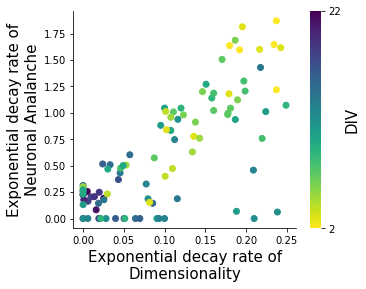

In [39]:
dish_list = ["19880","23312","23280","23311","23317","23302","23282"]
firingrate_thr = 0.03
DIV_min_plot = 2 # determine left limit
DIV_max_plot = 23 # right limit


fig, ax = plt.subplots(figsize=(5,4))

Dim_b = []
NA_b = []
DIV = []
for dish in dish_list:
    DIV_dish = DIV_all[dish]
    date_ok = np.where((np.array(firingrate_all[dish]) > firingrate_thr) * (DIV_dish < DIV_max_plot) * (DIV_dish >= DIV_min_plot))[0]
    Dim_b += list(np.array(abc_all[dish])[date_ok,1])
    NA_b += list(np.array(NA_abc_all[dish])[date_ok,1])
    DIV += list(DIV_dish[date_ok])
    
scatter = ax.scatter(Dim_b, NA_b, c=DIV, cmap='viridis_r')

corr, p_value = pearsonr(Dim_b, NA_b)
print("相関係数:", corr)
print("p値:", p_value)

cbar = plt.colorbar(scatter)
cbar.set_label('DIV', fontsize=15)
cbar.set_ticks([2,22])
cbar.outline.set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Exponential decay rate of\nDimensionality', fontsize=15)
plt.ylabel('Exponential decay rate of\nNeuronal Analanche', fontsize=15)
# plt.savefig("/root/code/paper_public/figs/fig3D.eps")
plt.show()    

3.0
15.0


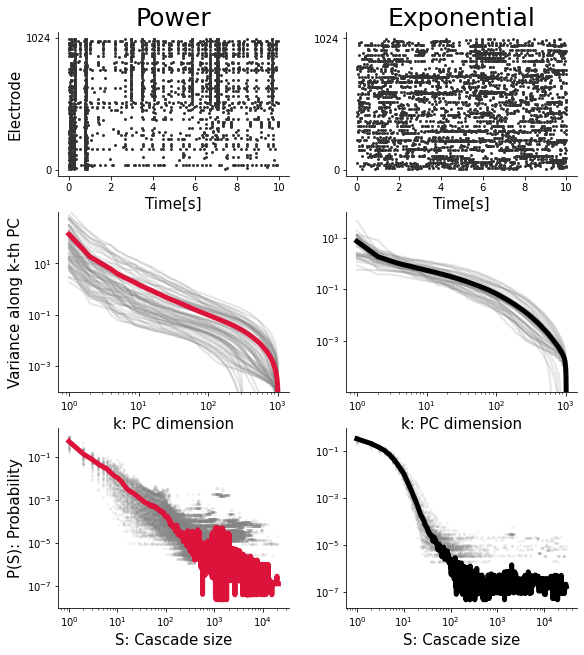

In [40]:
dish_list = ["19880","23312","23280","23311","23317","23302","23282"]
firingrate_thr = 0.03
N = 1024
DIV_min_plot = 0 # plotの右端を決める
DIV_max_plot = 23 # plotの右端を決める

fig = plt.figure(figsize=(8, 10))
ax1 = fig.add_axes([0.05, 0.65, 0.4, 0.2])  # [left, bottom, width, height]
ax2 = fig.add_axes([0.55, 0.65, 0.4, 0.2])
ax3 = fig.add_axes([0.05, 0.35, 0.4, 0.25])
ax4 = fig.add_axes([0.55, 0.35, 0.4, 0.25])
ax5 = fig.add_axes([0.05, 0.05, 0.4, 0.25])
ax6 = fig.add_axes([0.55, 0.05, 0.4, 0.25])


dish = "23312"
DIV_list = DIV_all[dish]
date_list = date_all[dish]
i_list = [1,10]
bin = 100

raster_time = 10 # [s]
times_list = []
channs_list = []

for i in range(len(i_list)):
    i_plot = i_list[i]
    date = date_list[i_plot]
    DIV = DIV_list[i_plot]
    print(DIV)
    
    path = f'/mnt/cerebellum/akita/development/data/{dish}/{date}/record.raw.h5'
    record = File(path)
    T = (record['data_store/data0000/stop_time'][0] - record['data_store/data0000/start_time'][0])/1000
    N = 1024
    times = np.array(pd.DataFrame(np.array(record['data_store/data0000/spikes']))['frameno']/20000)
    times -= times[0]
    channs = np.array(pd.DataFrame(np.array(record['data_store/data0000/spikes']))['channel'])
    
    nspike = np.sum(times < raster_time)
    times_list.append(times[:nspike])
    channs_list.append(channs[:nspike])
    
ax2.scatter(times_list[0],channs_list[0], s=15, marker=".", c='#333333')
ax1.scatter(times_list[1],channs_list[1], s=15, marker=".", c='#333333')



llim = 0.7
alpha_var = 0.2
alpha_size = 0.1

varspec_random = []
varspec_bursty = []
size_hist_random = []
size_hist_bursty = []

x_axis = np.arange(1,N+1)

for d in np.arange(len(dish_list)):
    dish = dish_list[d]
    varspec_dish = varspec_all[dish]
    size_hist_dish = size_hist_all[dish]
    DIV_dish = DIV_all[dish]
    
    for i in range(len(DIV_dish)):
        if firingrate_all[dish][i] > firingrate_thr:
            index = NA_abc_all[dish][i][1]
            if index < llim:
                varspec_bursty.append(varspec_dish[i])
                size_hist_bursty.append(size_hist_dish[i])
                ax3.plot(x_axis, varspec_dish[i], label=DIV_dish[i], color='gray', linewidth=2, alpha=alpha_var)
                ax5.scatter(np.where(size_hist_dish[i]>0)[0], size_hist_dish[i][size_hist_dish[i]>0], label=DIV_dish[i], color='gray', linewidth=2, alpha=alpha_size, s=1)     
            else:
                varspec_random.append(varspec_dish[i])
                size_hist_random.append(size_hist_dish[i])
                ax4.plot(x_axis, varspec_dish[i], label=DIV_dish[i], color='gray', linewidth=2, alpha=alpha_var)
                ax6.scatter(np.where(size_hist_dish[i]>0)[0], size_hist_dish[i][size_hist_dish[i]>0], label=DIV_dish[i], color='gray', linewidth=2, alpha=alpha_size, s=1)            


ax3.plot(x_axis, np.mean(varspec_bursty,axis=0), linewidth=5, color='crimson')
ax5.plot(np.where(np.mean(size_hist_bursty,axis=0)>0)[0], np.mean(size_hist_bursty,axis=0)[np.mean(size_hist_bursty,axis=0)>0], linewidth=5, color='crimson')

ax4.plot(x_axis, np.mean(varspec_random,axis=0), linewidth=5, color='black')
ax6.plot(np.where(np.mean(size_hist_random,axis=0)>0)[0], np.mean(size_hist_random,axis=0)[np.mean(size_hist_random,axis=0)>0], linewidth=5, color='black')

axs = [[ax1,ax2],[ax3,ax4],[ax5,ax6]]
for j in [0,1]:
    axs[0][j].set_xlabel(f'Time[s]',fontsize=15)
    axs[0][j].set_yticks([0,1024])
    axs[1][j].set_xscale('log')
    axs[1][j].set_yscale('log')
    axs[1][j].set_xlabel(f'k: PC dimension',fontsize=15)
    axs[1][j].set_yticks([1e-3,1e-1,1e1])
    axs[1][j].yaxis.set_minor_locator(NullLocator())
    axs[2][j].set_xscale('log')
    axs[2][j].set_yscale('log')
    axs[2][j].set_xlabel(f'S: Cascade size',fontsize=15)
    axs[2][j].set_yticks([1e-7,1e-5,1e-3,1e-1])
    axs[2][j].yaxis.set_minor_locator(NullLocator())
        
for i in [0,1,2]:
    for j in [0,1]:
        axs[i][j].spines['top'].set_visible(False)
        axs[i][j].spines['right'].set_visible(False)
        axs[i][j].patch.set_alpha(0)

ax1.set_title(f'Power',fontsize=25)
ax1.set_ylabel('Electrode',fontsize=15)
ax2.set_title(f'Exponential',fontsize=25)
ax3.set_ylabel('Variance along k-th PC',fontsize=15)
ax3.set_ylim([1e-4,1e3])
ax4.set_ylim([1e-5,1e2])
ax5.set_ylabel('P(S): Probability',fontsize=15)

# plt.savefig("/root/code/paper_public/figs/Sfig2B.eps")
plt.show()

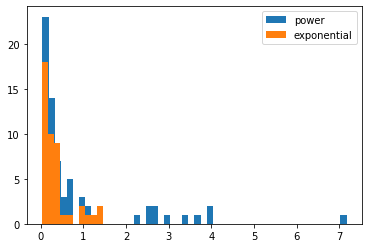

In [21]:
frate_l = []
frate_h = []

llim = 0.1
dish_list = ["19880","23312","23280","23311","23317","23302","23282"]
firingrate_thr = 0.03

for dish in dish_list:
    DIV_dish = DIV_all[dish]
    
    for i in range(len(DIV_dish)):
        if firingrate_all[dish][i] > firingrate_thr:
            index = abc_all[dish][i][1]
            if index < llim:
                frate_l.append(firingrate_all[dish][i])
            else:
                frate_h.append(firingrate_all[dish][i])
                
plt.hist(frate_l, bins=50, label="power")
plt.hist(frate_h, label="exponential")
plt.legend()